In [3]:
import pandas as pd
import numpy as np
from IPython.display import display, Latex
from sklearn.cluster import KMeans
from scipy.stats import norm

from utils.data_management import check_constraints, load_data, vectorized, inv_vectorized
from utils import cross_lambda_training
from utils.visualization import plot_codings_lamb, plot_rro

from models import model_selection
from models import DictionaryLearning
from models.gaussian_model import gaussian_transform, GaussianCopula

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [4]:
P = load_data()
pd.DataFrame(P)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,191
0,0.767199,0.767205,0.736855,0.748747,0.748338,0.771916,0.756948,0.904350,0.903882,0.903974,...,0.832057,0.803909,0.810724,0.767708,0.772607,0.766515,0.749932,0.734179,0.763076,0.778180
1,0.050118,0.055954,0.054800,0.052730,0.052412,0.063683,0.042119,0.041471,0.049926,0.048222,...,0.007518,0.007206,0.000000,0.001292,0.001327,0.001332,0.001248,0.001245,0.001239,0.000000
2,0.000561,0.000547,0.001595,0.001563,0.001525,0.014756,0.013023,0.012899,0.012411,0.012479,...,0.002459,0.000652,0.000641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.006975,0.006991,0.006832,0.006331,0.006306,0.006298,0.000000,0.000000,0.000000,0.000000,...,0.003521,0.003357,0.003591,0.002997,0.002923,0.002934,0.002941,0.003057,0.003068,0.002039
106,0.006737,0.006714,0.006634,0.007171,0.007151,0.007044,0.009697,0.004770,0.004725,0.004799,...,0.005506,0.004808,0.004692,0.004769,0.005557,0.007287,0.003980,0.008255,0.008245,0.006730
107,0.006235,0.006211,0.006286,0.006285,0.006299,0.006283,0.022471,0.022233,0.022326,0.022156,...,0.039539,0.039025,0.019506,0.013968,0.011628,0.011542,0.011345,0.011883,0.011612,0.008743
108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022627,0.023380,0.023310,0.023939,...,0.275891,0.292345,0.238223,0.250439,0.166759,0.166804,0.147356,0.146453,0.149397,0.088947


In [5]:
check_constraints(data=P)

(200, 110)
Inequality constraints unsatisfied: 67 (31.90%)
Equality constraints unsatisfied: 0 (0.00%)


In [6]:
# sparsity coefficient
np.count_nonzero(P)/(P.shape[0] * P.shape[1])

0.6025568181818182

In [7]:
# example of the first matrix P^t
pd.DataFrame(P[:, 0].reshape(10,11,order='F'), columns=np.arange(1,12), index=np.arange(1,11))

,1,2,3,4,5,6,7,8,9,10,11
1,0.767199,0.092597,0.000000,0.124510,0.000000,0.000000,0.000000,0.015694,0.000000,0.000000,0.000000
2,0.050118,0.819182,0.052280,0.047432,0.015789,0.015199,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000561,0.157136,0.667078,0.104888,0.012873,0.042320,0.000561,0.014583,0.000000,0.000000,0.000000
4,0.000000,0.027381,0.185256,0.682890,0.048760,0.039520,0.000815,0.004597,0.010780,0.000000,0.000000
5,0.000000,0.005614,0.029237,0.150391,0.661307,0.134347,0.006675,0.011803,0.000626,0.000000,0.000000
6,0.001082,0.001680,0.001651,0.021039,0.131511,0.719877,0.076555,0.026657,0.003340,0.009632,0.006975
7,0.000000,0.000000,0.000000,0.000427,0.014601,0.113097,0.749324,0.091771,0.018397,0.005646,0.006737
8,0.000000,0.000000,0.000587,0.009089,0.000000,0.032222,0.082259,0.852709,0.014197,0.002701,0.006235
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.009362,0.037446,0.178637,0.738490,0.036065,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.039409,0.000000,0.295019,0.000000,0.020525,0.608648,0.036398


In [8]:
# load monthly dates
sdate = date(2004, 1, 1)   # start date
edate = date(2020, 1, 1)   # end date

dates = pd.date_range(sdate,edate, freq='m')

**Objective function**
\begin{equation}
\label{eq:L2-reg} 
\min_{\mathbf D,\mathbf A, \mathbf w} ~ \|\mathbf P - \mathbf D\mathbf A\|_{\tt{F}}^2 + \lambda\sum_{k=1}^K\sum_{t =1}^{T-1} \left(\alpha_{k}^{t+1} - \bar\alpha_k - w_k(\alpha_{k}^{t}-\bar\alpha_k)\right)^2 .
\end{equation}
st
\begin{align}
    &\mathbf D \in \mathcal \Omega\\
    & \alpha_k^t \geq0, \text{ for all } t=1,\dots,T \text{ and } k=1,\dots,K,\\
\end{align}
with 
$$\bar\alpha_k = \frac{1}{T}\sum_{t=1}^T\alpha_k^t$$

%**AR Model**
%$$\alpha_{k}^{t+1} = \bar\alpha_k + w_k(\alpha_{k}^{t}-\bar\alpha_k) + \epsilon^t_k$$
%with 
%$$\epsilon^t_k\sim\mathcal N\left(0, Var[\alpha_k](1-w_k^2)\right)$$

In [9]:
N_MAT = P.shape[1]
n_test = int(0.2 * N_MAT)
P_test = P[:, -int(n_test):]
n_train = int(N_MAT-n_test)
P_train = P[:, :int(N_MAT-n_test)]
P_full = pd.DataFrame(P)
K = 3

# Lags selection

Plot the Partial Autocorrelation of the codings $\mathbf{A}^{\rm{Train}}$ without regularization ($\lambda=0$)

In [16]:
model = DictionaryLearning(K=K, r_dim=11)
model.fit(P_train, lamb=0., max_iter=500)

/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cvxopt/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use th

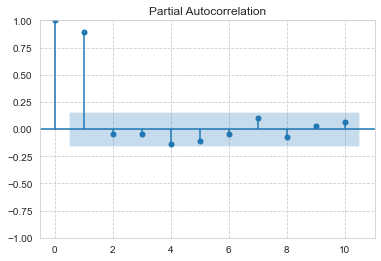

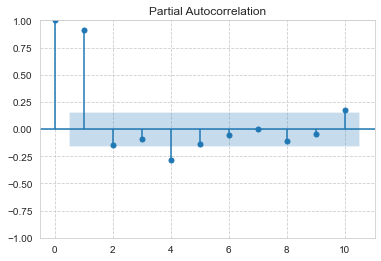

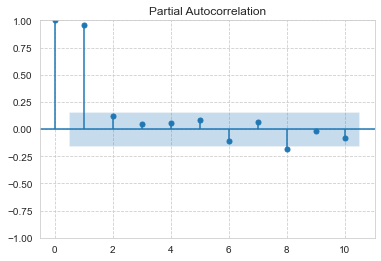

In [17]:
for k in range(K):
    _=plot_pacf(x=model.A[k, :], lags=10)

# Reconstruction / Regularization / Objective
Fit the Dictionary Learning and study the RRO for different values of $\lambda$

## K=3

In [659]:
dict_reco3, dict_regu3, dict_obj3, dict_codings3 = cross_lambda_training(P=P_train, K=3, 
                                                        r_dim=11,
                                                        list_lambdas=[0.1, 1, 6, 10])

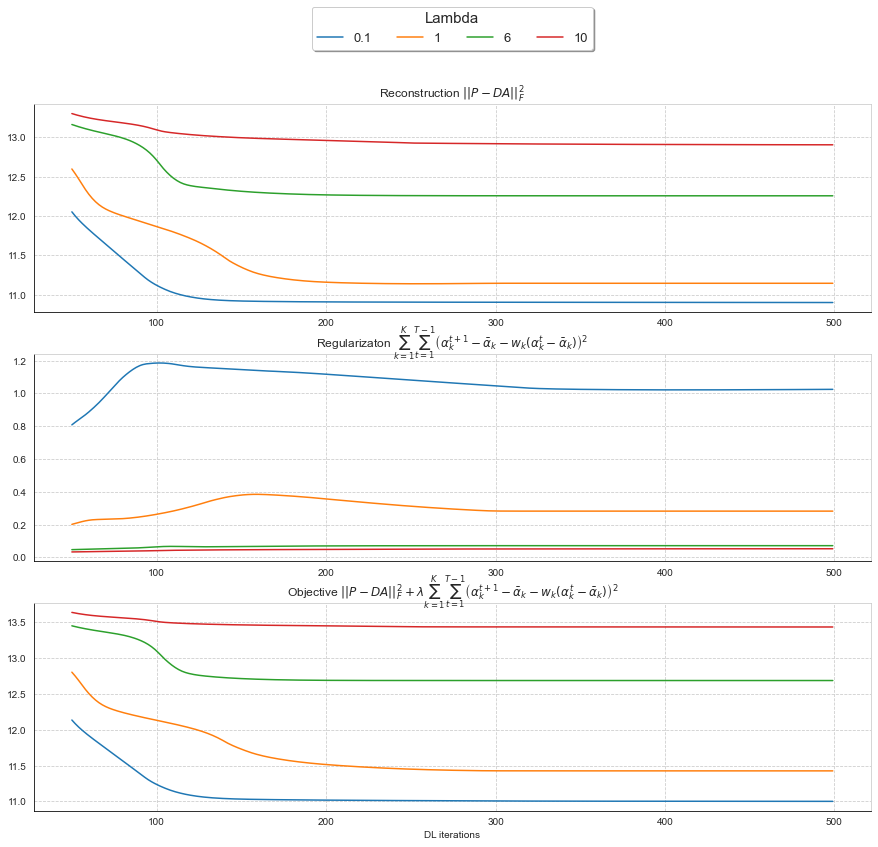

In [660]:
plot_rro(dict_reco3, dict_regu3, dict_obj3, trunc=50)

In [661]:
for key, val in dict_reco3.items():
    print("lambda={} ; RMSE={:.3f}".format(key, np.sqrt(val[-1]/n_train)))

lambda=0.1 ; RMSE=0.266
lambda=1 ; RMSE=0.269
lambda=6 ; RMSE=0.282
lambda=10 ; RMSE=0.289


### Codings

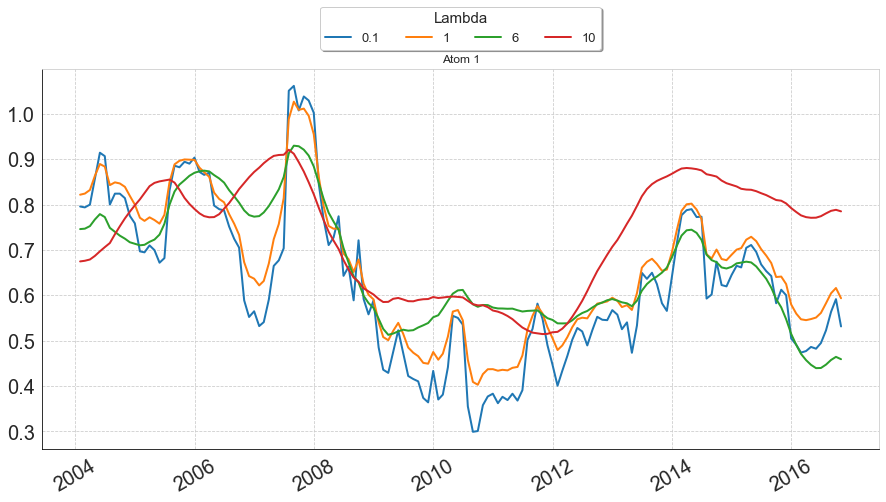

In [662]:
plot_codings_lamb(dict_codings3, atom=1)

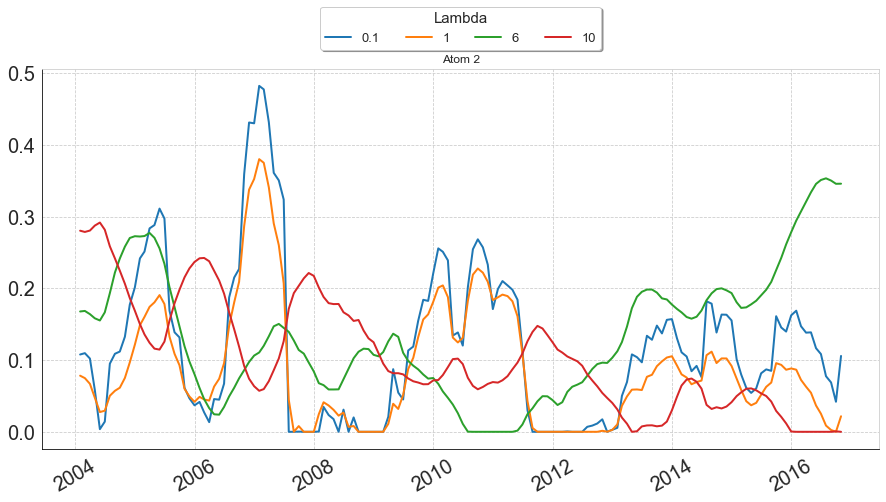

In [663]:
plot_codings_lamb(dict_codings3, atom=2)

In [102]:
plot_codings_lamb(dict_codings3, atom=3)

# Hyper-parameter selection

In [23]:
IFrame("imgs/hyperparameter_selection.pdf", width=600, height=600)

In [27]:
df_selection = model_selection(P, list_K=[2,3,4,5,6,7,8,9,10], 
                               list_lambdas=[0.01, 0.1, 0.5, 1, 3, 5, 10, 50], 
                               test_size=0.2, replications=100)
df_selection

,0.01,0.10,0.50,1.00,3.00,5.00,10.00,50.00
2,-73.943365,-68.296292,-2.839245,76.016377,274.423426,399.099044,599.398656,1271.636769


In [87]:
#df_selection.to_csv("ckpt/model_selection.csv")

# Fit selected DL Model

In [29]:
# run the model with the hyper-parameter selected
model = DictionaryLearning(K=3, r_dim=11)
model.fit(P_train, lamb=0.1, max_iter=500)

In [24]:
test_size = 0.2
n_mat = P.shape[1]
n_test = int((test_size) * n_mat)
Ptest = P[:, -int(n_test):]
Ptrain = P[:, :int(n_mat - n_test)]
A_test = np.linalg.inv(model.D.T @ model.D) @ model.D.T @ Ptest

mu = model.mu.reshape(-1, 1)
# cov = np.diag(np.var(model.A, axis=1) * (1 - model.W ** 2))  # diagonal is the estimated variance of the noise
var = np.var(model.A, axis=1) * (1 - model.W ** 2)
A_pred = mu + (model.W.reshape(-1, 1) * A_test[:, :-1])  # without last Atest
nll = 1/(2*var) * np.sum((A_test[:, 1:]-A_pred)**2,  axis=1) + ((n_test-1)*np.log(np.sqrt(var)) ) # negative log-likelihood

# Coding prediction

In [30]:
model.W

array([0.94030492, 0.91881743, 0.97725679])

In [14]:
model.mu

array([ 0.04320657,  0.00588789,  0.00323151, -0.00048919,  0.0118571 ])

In [83]:
A_test = np.linalg.inv(model.D.T @ model.D) @ model.D.T @ P_test
REPLICATIONS = 10000

list_Asim = []
list_Psim = []
for rep in range(REPLICATIONS):
    A_sim = model.predicted_codings(model.A[:, -1].reshape(-1,1), steps=12, seed=rep) 
    P_sim = model.D @ A_sim
    list_Psim.append(P_sim)
    

Psim_Qlow = np.percentile(np.array(list_Psim), 2.5, axis=0)
Psim_Qlow = np.maximum(0, Psim_Qlow)
Psim_Qhigh = np.percentile(np.array(list_Psim), 97.5, axis=0)
Psim_Qhigh = np.minimum(1, Psim_Qhigh)

/Users/michaelallouche/PhD/repos/dictionary-learning-rmm/dictionary-learning-RMM/models/dictionary_learning.py:208: RuntimeWarning: covariance is not positive-semidefinite.
  eps = np.random.multivariate_normal(np.zeros(self.K), cov, 1).T


In [84]:
display(pd.DataFrame(model.inv_vectorized(Psim_Qlow, 10, 11),
                    index=np.arange(1, 11), columns=np.arange(1, 12)).round(4)*100)

,1,2,3,4,5,6,7,8,9,10,11
1,79.69,4.40,0.36,0.87,0.07,0.43,0.12,0.03,0.03,0.00,0.05
2,2.74,69.93,10.22,1.54,0.50,0.35,0.18,0.31,0.06,0.10,0.05
3,0.54,6.64,69.94,5.30,1.63,1.06,0.19,0.31,0.10,0.12,0.09
4,0.33,0.69,9.73,65.72,6.15,1.84,0.51,0.31,0.10,0.14,0.12
5,0.32,0.26,1.53,12.47,61.25,7.34,1.39,0.46,0.19,0.37,0.15
6,0.19,0.29,0.46,1.78,12.87,60.04,6.97,1.59,0.39,0.58,0.55
7,0.19,0.25,0.29,0.51,2.26,13.43,57.12,8.39,1.62,0.46,1.02
8,0.19,0.23,0.27,0.30,0.98,2.97,16.31,55.40,4.03,2.04,2.34
9,0.19,0.23,0.26,0.29,0.88,1.55,5.29,8.75,53.26,4.54,5.77
10,0.00,0.00,0.00,0.00,0.38,0.40,6.01,4.81,14.54,40.72,15.41


In [85]:
display(pd.DataFrame(model.inv_vectorized(Psim_Qhigh, 10, 11),
                    index=np.arange(1, 11), columns=np.arange(1, 12)).round(4)*100)

,1,2,3,4,5,6,7,8,9,10,11
1,100.00,10.43,1.68,1.83,0.22,0.79,0.17,0.05,0.05,0.00,0.23
2,3.66,98.85,14.23,2.77,0.68,0.57,0.26,0.40,0.10,0.16,0.24
3,0.69,8.43,100.00,7.88,2.16,1.37,0.27,0.41,0.14,0.18,0.28
4,0.44,0.92,12.41,93.69,10.75,2.43,0.65,0.41,0.14,0.21,0.30
5,0.44,0.33,1.96,16.00,89.26,10.08,2.11,0.75,0.33,0.58,0.33
6,0.26,0.39,0.58,2.36,16.57,85.75,11.17,2.18,0.80,0.90,1.22
7,0.25,0.34,0.39,0.70,3.04,17.45,83.46,11.61,2.59,0.71,1.81
8,0.25,0.32,0.37,0.41,1.36,4.01,23.29,78.53,6.97,3.19,4.17
9,0.25,0.32,0.35,0.40,1.19,2.21,6.69,14.68,68.33,13.17,19.33
10,0.00,0.00,0.00,0.00,0.52,0.55,8.06,7.01,19.85,59.97,29.75


# Dictionary

In [31]:
for atom in range(1, K+1):
    display(Latex("$d_{}$".format(atom)))
    display(pd.DataFrame(model.inv_vectorized(model.D[:, atom-1], 10, 11),
                        index=np.arange(1, 11), columns=np.arange(1, 12)).round(4)*100)

<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,92.89,4.42,0.00,1.52,0.00,0.51,0.31,0.17,0.07,0.00,0.12
2,2.30,88.04,6.73,1.25,0.51,0.51,0.31,0.17,0.04,0.03,0.12
3,0.65,7.13,77.99,10.05,2.52,0.99,0.30,0.17,0.04,0.03,0.12
4,0.18,0.96,9.93,79.25,5.84,3.03,0.44,0.17,0.04,0.03,0.12
5,0.17,0.19,1.60,10.04,75.61,9.42,2.03,0.62,0.15,0.07,0.12
6,0.04,0.13,0.42,1.35,10.36,79.34,6.50,1.16,0.18,0.32,0.19
7,0.04,0.13,0.10,0.30,1.20,10.10,78.70,7.70,1.17,0.18,0.39
8,0.04,0.10,0.08,0.04,0.43,2.01,10.64,84.14,1.95,0.18,0.39
9,0.00,0.00,0.00,0.00,0.15,0.47,4.92,6.24,87.65,0.18,0.39
10,0.00,0.00,0.00,0.00,0.15,0.37,3.48,0.00,5.59,84.80,5.61


<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,91.43,8.57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.27,91.29,8.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.27,7.85,87.30,0.19,3.14,1.22,0.00,0.03,0.00,0.00,0.00
4,0.26,2.95,10.37,82.02,3.05,1.30,0.01,0.04,0.00,0.00,0.00
5,0.26,0.88,0.78,14.52,75.80,7.71,0.00,0.04,0.00,0.00,0.00
6,0.26,0.30,1.23,1.34,13.87,75.00,5.84,2.16,0.00,0.00,0.00
7,0.26,0.30,0.46,0.79,2.47,13.39,80.16,2.17,0.00,0.00,0.00
8,0.26,0.30,0.45,0.80,1.57,1.64,13.14,81.84,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.09,3.81,14.27,61.27,17.86,2.71,0.00
10,0.00,0.00,0.00,0.00,0.08,0.00,3.41,75.94,17.86,0.17,2.54


<IPython.core.display.Latex object>

,1,2,3,4,5,6,7,8,9,10,11
1,73.18,17.63,3.60,2.54,0.73,1.82,0.00,0.00,0.00,0.00,0.50
2,0.00,82.99,9.86,4.10,0.73,0.83,0.35,0.17,0.25,0.22,0.50
3,0.00,0.00,88.51,8.43,0.74,0.83,0.35,0.17,0.25,0.22,0.50
4,0.00,0.00,0.13,81.89,14.96,1.36,0.51,0.17,0.24,0.23,0.50
5,0.00,0.00,0.13,3.57,82.87,8.15,2.52,1.03,0.45,0.77,0.51
6,0.00,0.00,0.13,1.19,5.32,74.59,12.98,1.46,1.30,0.88,2.14
7,0.00,0.00,0.13,0.55,1.43,5.83,77.09,9.22,2.45,0.78,2.51
8,0.00,0.00,0.13,0.28,0.63,0.66,17.34,61.66,8.67,4.30,6.32
9,0.00,0.00,0.13,0.28,0.61,0.68,0.00,15.24,13.98,26.55,42.52
10,0.00,0.00,0.00,0.00,0.00,0.00,1.71,0.00,1.03,53.85,43.42


# Clustering (K-Means)

In [32]:
# Model
#n_test = int(0.2 * N_MAT)
#P_test = P[:, -int(n_test):]
#n_train = int(N_MAT-n_test)
#P_train = P[:, :int(N_MAT-n_test)]
#
#K = 3
#LAMB = 0.1
#
## build train model
#model = DictionaryLearning(K=K, r_dim=11)
#model.fit(P_train, lamb=LAMB, max_iter=500)

In [33]:
# Stadardization of training codings
A_mean = model.A.mean(axis=1).reshape(-1,1)
A_std = model.A.std(axis=1).reshape(-1,1)
A_scaled = ((model.A - A_mean) / A_std).T

In [34]:
N_CLUSTERS = 3
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

KMeans(init='random', n_clusters=3, random_state=42)

In [35]:
# Fit Kmean
kmeans = KMeans(
     init="random",
     n_clusters=N_CLUSTERS,
     n_init=10,
     max_iter=300,
     random_state=42)

kmeans.fit(A_scaled)

# Final locations of the centroids
kmeans.cluster_centers_

array([[-0.65817804, -0.14429411,  0.71748986],
       [ 1.21899472, -0.48391028, -0.88447339],
       [ 0.17568147,  1.95813016, -1.32712842]])

In [36]:
# Final predictions
y_train_pred = kmeans.labels_
y_train_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [71]:
K=3
LAMB = 0.1

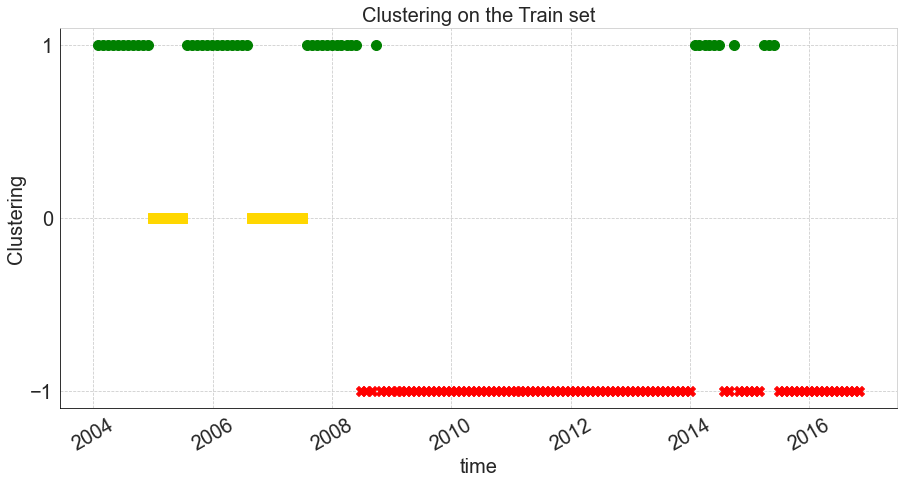

In [72]:
dict_labels={"green": 1, "gold":2, "red":0}


fig, ax = plt.subplots(1, 1, figsize=(15,7),)

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["red"])[0]], 
            -1*np.ones_like(np.where(y_train_pred == dict_labels["red"])[0]), 
            color="red", s=100, marker="X")

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["gold"])[0]], 
            np.zeros_like(np.where(y_train_pred == dict_labels["gold"])[0]), 
            color="gold", s=100, marker="s")

ax.scatter(dates[:n_train][np.where(y_train_pred == dict_labels["green"])[0]], 
            np.ones_like(np.where(y_train_pred == dict_labels["green"])[0]), 
            color="green", s=100, marker="o")

ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")

_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

ax.set_yticks([-1, 0 , 1])

#print("Train")
#epstopdfplt.savefig("imgs/clustering/cluster_train-K{}-lamb{}.eps".format(K, LAMB), format="eps")
plt.xlabel("time", fontsize=20)
plt.ylabel("Clustering", fontsize=20)
_ = plt.title("Clustering on the Train set", fontsize="20")

## Infer an economic sentiment indicator

**Plot the repartition of the clusters**

In [66]:
# labels associated with the red cluster
CLUSTER = "green"  # pick the color
cluster_times = np.where(y_train_pred == (dict_labels[CLUSTER]))[0]
cluster_times

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  56, 120, 121, 122,
       123, 124, 125, 128, 134, 135, 136])

In [67]:
# average the associated codings alpha
alpha_avg = model.A[:, cluster_times].mean(axis=1) #.round(1)
np.round(alpha_avg*100, 1)

array([83.2,  6.6, 10.2])

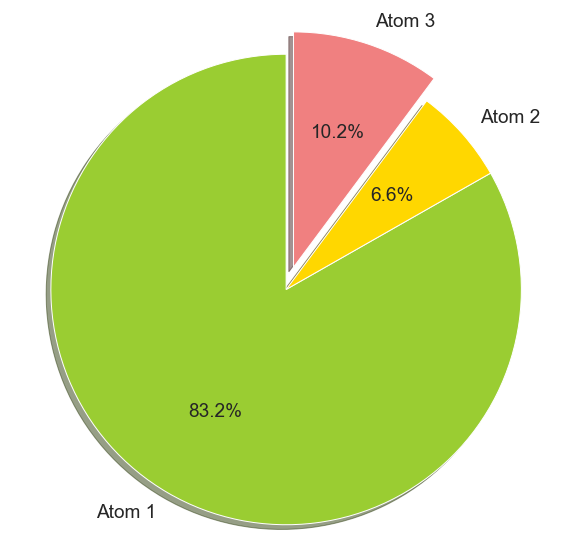

In [69]:
atoms = ["Atom {}".format(k) for k in np.arange(1, K+1)]
fig, ax = plt.subplots(figsize=(10, 10))
explode = (0, 0, 0.1)  # explode 1st slice
colors = ['yellowgreen', 'gold', 'lightcoral']

ax.pie(alpha_avg, labels=atoms, explode=explode, autopct='%.1f%%',
       colors=colors, shadow=True, startangle=90, textprops={'fontsize': 19}) # 

_=plt.axis('equal')
#plt.savefig("imgs/clustering/pie_train-group{}.eps".format(dict_labels["red"]), format="eps")

# Gaussian Copula Model
\begin{align*}
	P_{i,\geq j}^t&=\Phi\left(\frac{\rho Z^t+\Phi^{-1}(P^{TTC}_{i, \geq j})}{\sqrt{1-\rho^2}}\right),
\end{align*}    

Apply the Gaussian transform to RMM for all $t\in[T], i\in[R-1], j\in[R]$:
	\begin{align*}
		{P}^{\Phi, t}_{i, \geq j} :=\Phi^{-1} \left({P}^t_{i, \geq j} \right),
	\end{align*}

In [40]:
gc_model = GaussianCopula()
gc_model.fit(P_train)

In [41]:
P_Phi = gc_model.P_Phi

In [42]:
# exemple of the first P_Phi column in matrix form
pd.DataFrame(inv_vectorized(P_Phi[:, 0], nrow=10, ncol=11))

,0,1,2,3,4,5,6,7,8,9,10
0,8.209536,-0.729652,-1.079403,-1.079403,-2.152107,-2.152107,-2.152107,-2.152107,-8.222082,-8.222082,-8.222082
1,8.209536,1.643711,-1.123090,-1.415781,-1.866468,-2.164861,-8.222082,-8.222082,-8.222082,-8.222082,-8.222082
2,8.209536,3.258052,1.003968,-0.933717,-1.473287,-1.576423,-2.166296,-2.181225,-8.222082,-8.222082,-8.222082
3,8.209536,8.041400,1.920763,0.797304,-1.256470,-1.591818,-2.139615,-2.160225,-2.298024,-8.222082,-8.222082
4,8.209536,8.125891,2.535493,1.813837,0.895565,-1.021747,-2.072636,-2.243624,-3.226870,-8.222082,-8.222082
5,8.209536,3.066791,2.774826,2.618736,1.952289,1.007017,-1.159333,-1.678703,-2.054828,-2.129478,-2.458544
6,8.209536,8.014016,8.014016,8.014016,3.334668,2.169346,1.135297,-1.162330,-1.869452,-2.245028,-2.470978
7,8.209536,8.076571,8.076571,3.245053,2.338675,2.338675,1.729067,1.154452,-1.992950,-2.368246,-2.498531
8,8.209536,8.076571,8.076571,8.076571,8.076571,8.076571,2.350998,1.676626,0.753932,-1.798296,-8.222082
9,8.209536,8.076571,8.076571,8.076571,8.076571,1.757587,1.757587,0.427719,0.427719,0.371981,-1.794102


and
$$P^{\Phi,\rm TTC}_{i, j} := \Phi^{-1}(\widehat {P^{\rm TTC}}_{i,\geq j})$$
where 
$$\widehat {P^{\rm TTC}}_{i,\geq j} = \frac{1}{T}\sum_{t=1}^T P^t_{i, \geq j}$$.

In [43]:
P_Phi_TTC = gc_model.P_Phi_TTC

In [44]:
# display the P^{Phi, TTC} in matrix form
pd.DataFrame(inv_vectorized(P_Phi_TTC, nrow=10, ncol=11))

,0,1,2,3,4,5,6,7,8,9,10
0,8.209536,-1.156416,-1.734382,-1.810220,-2.048541,-2.050380,-2.259543,-2.322163,-2.350860,-2.405171,-2.464668
1,8.209536,2.208196,-1.216279,-1.839318,-2.202413,-2.396189,-2.679799,-2.984839,-3.343891,-3.343891,-3.343891
2,8.209536,2.688805,1.593344,-1.158402,-1.784180,-2.173943,-2.576281,-2.789922,-2.991860,-3.076146,-3.124286
3,8.209536,3.042492,2.303015,1.369356,-1.226030,-1.869274,-2.476938,-2.804150,-3.046045,-3.138694,-3.208658
4,8.209536,3.018053,2.703205,2.189159,1.258450,-1.178341,-1.877906,-2.281261,-2.574221,-2.725177,-3.056308
5,8.209536,3.784244,3.072677,2.534755,2.084976,1.206531,-1.233165,-1.916916,-2.188776,-2.325164,-2.501989
6,8.209536,4.356505,3.167962,2.902735,2.538578,2.064879,1.207003,-1.279374,-1.944915,-2.228174,-2.339395
7,8.209536,4.391762,3.948242,3.336567,3.020325,2.491118,2.021511,1.043620,-1.482957,-1.808850,-2.031936
8,8.209536,8.076571,8.076571,8.076571,3.276224,2.714377,2.219619,1.546433,0.799759,-0.905360,-1.225648
9,8.209536,8.076571,3.137247,3.137247,3.137247,2.686442,2.444024,1.745496,1.178981,0.918905,-1.025191


We should get (in the stationary regime) 
\begin{align*}
	P^{\Phi, t}_{i, \geq j} \approx \alpha_1^t + \alpha_2 P^{\Phi, \rm TTC}_{i, \geq j},
\end{align*}
where 
\begin{align*}
	\alpha_1^t \overset{d}{\approx} \mathcal N\left(0, \frac{\rho^2}{{1-\rho^2}}\right), \qquad  \alpha_2 \approx \frac{1}{\sqrt{1-\rho^2}}.
\end{align*}

**Objective function.**
\begin{align*}
	\min_{\alpha_2}\frac{1}{T}\sum_{t=1}^{T} \sum_{j=1}^{11}\sum_{i=1}^{10}\left(P^{\Phi, t}_{i, \geq j} - \alpha_2P^{\Phi, \rm TTC}_{i, \geq j} \right)^2,
\end{align*}

In [45]:
# parameter estimation
alpha2_hat = gc_model.get_coef()
alpha2_hat

1.3603210329063096

\begin{align*}
	\hat \rho = \pm \sqrt{1 - \left(\frac{1}{\hat\alpha_2}\right)^2}.
\end{align*}

In [46]:
# estimated rho
rho_hat = np.sqrt(1 - (1/alpha2_hat)**2)
rho_hat

0.6779363675757101

Then, computing the mean residuals for all $ t\in[T] $,
\begin{align*}
	{\widehat{\alpha_1^t}}= {\frac{1}{d}} \sum_{j=1}^{R}\sum_{i=1}^{R-1}\left(P^{\Phi, t}_{i, {\geq} j} - \widehat{\alpha_2}P^{\Phi, \rm TTC}_{i, {\geq} j} \right),
\end{align*}
 we obtain an estimate 
\begin{align}
\label{eq:Zt:est}
	\widehat Z^t = \frac{\sqrt{1-\widehat\rho^2}}{\widehat\rho}{\widehat{\alpha_1}^t}.
\end{align}

In [47]:
alpha1_hat = gc_model.get_residuals()
Zt_hat = alpha1_hat * np.sqrt(1-rho_hat**2) / rho_hat

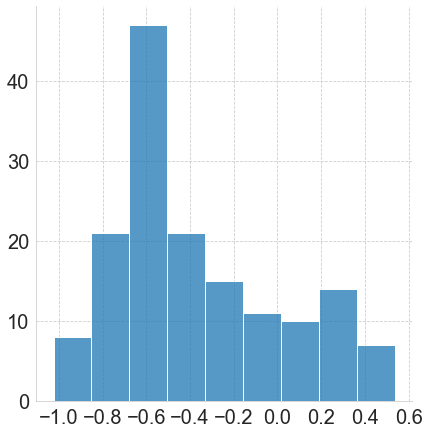

In [48]:
# Histogram of Zt_hat
sns.displot(Zt_hat, aspect=1, height=6)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.ylabel("")

#plt.savefig("imgs/gaussian_copula/Zhist.eps", format="eps")

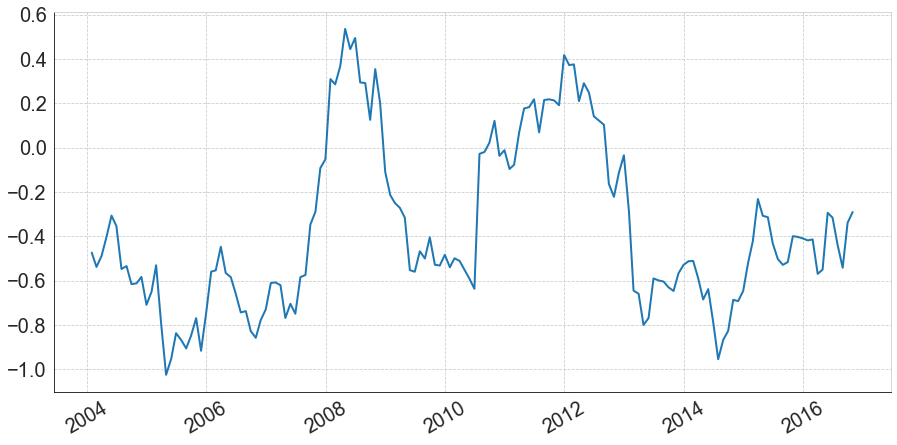

In [49]:
# Series of Zt
fig, ax = plt.subplots(1, 1, figsize=(15,7),)
ax.plot(dates[:n_train], 
            Zt_hat, 
            linewidth=2)
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
_=plt.xticks(fontsize=20, rotation=30)
_=plt.yticks(fontsize=20)

#plt.savefig("imgs/gaussian_copula/Zseries.eps", format="eps")

Finally, we obtain the reconstructed RMM $\mathbf P^{\tt GC}$
\begin{align*}
	P^{{\tt GC}, t}_{i,j} = \Phi\left(\widehat{P}^{\Phi, t}_{i, \geq j}\right)	-  \Phi\left(\widehat{P}^{\Phi, t}_{i, \geq j+1}\right),	
\end{align*}
with ,
\begin{align*}
	\widehat{P}^{\Phi, t}_{i, \geq j} := \widehat \alpha_1^t + \widehat \alpha_2 P^{\Phi, TTC}_{i, \geq j}
\end{align*}
where by convention 
\begin{align*}
\widehat{P}^{\Phi, t}_{i, R+1} = -\infty
\end{align*}

In [50]:
P_GC = gc_model.P_GC

$${\rm RMSE} = \sqrt{\frac{1}{T}\sum_{t=1}^T\sum_{j=1}^{R-1}\sum_{i=1}^{R}\left(P^t_{i,j} - P^{{\tt GC}, t}_{i,j}\right)^2}$$

In [51]:
reconstruction_rmse = np.sqrt((np.linalg.norm(P_train - P_GC) ** 2) / n_train)
print("The GC reconstruction RMSE is {:.6f}".format(reconstruction_rmse))

The GC reconstruction RMSE is 0.527227


In [53]:
for lamb in [0, 0.5, 1]:
    model_DL = DictionaryLearning(K=2, r_dim=11)
    model_DL.fit(P_train, lamb=lamb, max_iter=500)
    reconstruction_DL = np.sqrt((np.linalg.norm(P_train - model_DL.D @ model_DL.A) ** 2) / n_train)
    print("The DL (K=2, lamb={}) reconstruction RMSE is {:.6f}".format(lamb, reconstruction_DL))

The DL (K=2, lamb=0) reconstruction RMSE is 0.303579
The DL (K=2, lamb=0.5) reconstruction RMSE is 0.305795
The DL (K=2, lamb=1) reconstruction RMSE is 0.306811


In [52]:
for lamb in [0.1]:
    model_DL = DictionaryLearning(K=2, r_dim=11)
    model_DL.fit(P_train, lamb=lamb, max_iter=500)
    reconstruction_DL = np.sqrt((np.linalg.norm(P_train - model_DL.D @ model_DL.A) ** 2) / n_train)
    print("The DL (K=2, lamb={}) reconstruction RMSE is {:.6f}".format(lamb, reconstruction_DL))

The DL (K=2, lamb=0.1) reconstruction RMSE is 0.304223
